# Exploring the Use of Raw Force Time Data Points to Evaluate Jump Performance 
### William Zhao

This code was created for the OBEL Lab 'Hack-a-thon' where we were tasked to 
use raw force plate data to evaluate CMJ performance of various UWaterloo athletes.
The goals were to:

    1) Be able to demarcate each phase of the jump based on F/T data provided
    
    2) Calculate specific output metrics
    
    3) Determine whether there are any variables that have strong relationships with jump height
    
    4) Predict the draft round for half of the athletes


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.integrate import cumulative_trapezoid
import statsmodels.formula.api as sm
#Import OBEL Force Plate data
obel = pd.read_csv('C:\\Users\\Willi\\OneDrive\\Desktop\\Data Science Learning\\Data\\OBEL FP Hackathon.csv')
#Define constants
Sample_Freq = 1000 #Hawkins FP samples at 1000Hz
Gravity = 9.81


In [2]:
# The data was given to us prefiltered, but this is how I would filter if needed

#Extract raw force data (Fz) from all athletes
raw_force = obel.iloc[:, 4:]
#Extract time which are the column titles
time = raw_force.columns
#Force data for each athlete is in rows, so we need to first transpose the dataframe
raw_force = raw_force.transpose()
#Filter raw force data
cutoff_freq = 50 / (Sample_Freq * 0.5) #Normalize cutoff freq
b, a = butter(4 , cutoff_freq , btype = 'low') #Determine filter coefficients for 4th order butterworth filter
filt_force = filtfilt(b , a , raw_force)
#Transpose the filtered force data back to rows
filt_force = filt_force.transpose()
#Combine filtered force and time back into a dataframe
filt_force = pd.DataFrame(filt_force , columns = time)
#Combine filtered force back to original athlete dataframe
athlete = obel.iloc[:, :4]
obel_filtered = pd.merge(athlete , filt_force , left_index= True, right_index=True)

In [3]:
# Extract Data and Identify Key Time Points

#Extract athlete data
athlete = obel.iloc[:, :4]

#Prepare a dataframe with each athlete and unique visit to hold output metrics
athlete_output = athlete.iloc[::2 , [0,1,3]].reset_index(drop = True) #Take the columns that include athlete number, visit date, and draft round, and every other entry since there are 2 entries per athlete visit

#Extract force data (Fz) from all athletes
force = obel.iloc[:, 4:]
#Extract time which are the column titles, then find the last time entry to cut data
time = force.columns
time_series = time.to_list() #Convert index to list
time_series = [t for t in time_series if t.replace('.', '', 1).isdigit()] # Get rid of non-time entries
time_series= np.array(time_series, dtype=float)
last_time_value = time_series[-1] #Retrieve the the final time value 
time_series = time_series[:-1] #Trim time series to allow integration later

# Find the column corresponding to the last time value
force.columns = pd.to_numeric(force.columns, errors='coerce')
# Get the index of the column
col_index = force.columns.get_loc(last_time_value)
# Slice the DataFrame from this column onwards
force = force.iloc[:, :col_index]
force.columns = force.columns.astype(str)

#Calculate body weight (N) as the average of the first second of data
#Since the data is split into left and right leg, I want to first sum them together
force_t = force.transpose()
sum_force = [force_t.iloc[:, i] + force_t.iloc[:, i + 1] for i in range (0, force_t.shape[1], 2)] #Output is a list
sum_force = pd.DataFrame(sum_force) #List to dataframe
sum_force = sum_force.transpose()
body_weight = sum_force.iloc[:Sample_Freq].mean()#Body weight (N)

#Identify Onset of Movement
body_weight_t = body_weight.transpose()
onset_threshold_n = body_weight_t - 5 * np.std(sum_force[:Sample_Freq]) #Negative threshold
onset_threshold_p = body_weight_t + 5 * np.std(sum_force[:Sample_Freq]) #Positive threshold
onset_threshold_p = onset_threshold_p.squeeze() #Convert df to series
onset_threshold_n = onset_threshold_n.squeeze()
# Generate a dictionary to store onset times
onset_indices = {}
# For loop to compute onset time
for col in sum_force.columns:
    # Compute condition for the current column
    condition = (sum_force[col].iloc[10:] > onset_threshold_p[col]) | (sum_force[col].iloc[10:] < onset_threshold_n[col])
    # Find the index of the first occurrence where the condition is met
    onset_index = condition.idxmax() if condition.any() else None
    # Store the onset index in the dictionary
    onset_indices[col] = (float(onset_index)) #Convert from string to float
    
#Calculate onset time 30ms before threshold trigger
onset_time = {key : value - 0.03 for key , value in onset_indices.items()} 

#Identify off plate (start of flight) and landing (end of flight)
off_plate_time = {}
landing_time = {}
zero_time = {}
for col in sum_force.columns:
    #Compute condition for the current columns
    condition_flight = (sum_force[col] < 5)
    #Find the index of the first occurance where condition is met
    flight_index = condition_flight.idxmax() if condition_flight.any() else None
    #Store the flight index in dictionary
    off_plate_time[col] = float(flight_index)

for col in sum_force.columns:
    values = sum_force[col]
    
    # Find the index of the first occurrence where value is 0
    zero_index = values[values <= 15].index
    zero_index = zero_index[0] if not zero_index.empty else None
    zero_time[col] = zero_index

    # Find the first index where values are > 20 after zero_index
    if zero_index is not None:
        # Filter the DataFrame to consider values only after zero_index
        after_zero = values[values.index > zero_index]
        
        # Find the first instance where values are greater than 50
        land_index = after_zero[after_zero > 50].index
        landing_time[col] = float(land_index[0]) if not land_index.empty else None

#Calculate accel, velocity, position using F=ma
body_mass_kg= body_weight_t / Gravity

#Acceleration
accel = pd.DataFrame(index = sum_force.index, columns = sum_force.columns)
for athlete_index in range (40):
    body_weight = body_weight_t.iloc[athlete_index]
    body_mass = body_mass_kg.iloc[athlete_index]
    accel.iloc[:, athlete_index] = (sum_force.iloc[:, athlete_index] - body_weight) / body_mass

#Velocity
velo = pd.DataFrame(index=accel.index, columns=accel.columns)
for col in accel.columns:
    velo[col] = cumulative_trapezoid(accel[col], time_series, initial=0)

#Position
position = pd.DataFrame(index=velo.index, columns=velo.columns)
for col in velo.columns:
    position[col] = cumulative_trapezoid(velo[col], time_series, initial=0)

##Identify CMJ Phases
##Unweighting end: after onset index, when velocity is minimum
velo = velo.T
position = position.T

# Convert column names of velo_t to numeric
velo.columns = pd.to_numeric(velo.columns, errors='coerce')
position.columns = pd.to_numeric(position.columns, errors = 'coerce')
off_plate_time = np.array(list(off_plate_time.values()))
onset_time = np.array(list(onset_time.values()))

# Initialize a list to store the results
unweighting_end_times = []

# Iterate over each athlete
for athlete_index in range(40):
    # Get the current athlete's onset and off-plate time
    onset = onset_time[athlete_index]
    off = off_plate_time[athlete_index]

    # Filter the DataFrame to get velocity data within the specified time range
    mask = (velo.columns >= onset) & (velo.columns <= off)
    filtered_velocities = velo.iloc[athlete_index, mask]

    # Find the index of the minimum velocity within the filtered range
    min_velocity_index = filtered_velocities.idxmin()

    # Get the corresponding time for the minimum velocity
    unweighting_end_time = min_velocity_index
    unweighting_end_times.append(unweighting_end_time)

# Convert the list to a DataFrame for easier analysis
unweighting_end_times = pd.DataFrame(unweighting_end_times, columns=['End of Unweighting Phase'])

##Braking end: Unweighting end, when vleocity crosses 0
    
# Initialize a list to store the results
braking_end_times = []

# Iterate over each athlete
for athlete_index in range(40):
    # Get the current athlete's unweight time
    unweight = unweighting_end_times.iloc[athlete_index,0]

    # Filter the DataFrame to get velocity data within the specified time range
    mask_braking = velo.columns > unweight 
    braking_velocities = velo.iloc[athlete_index, mask_braking]

    # Find the index of the minimum velocity within the filtered range
    cross_zero_index = braking_velocities[braking_velocities >= 0].index.min()
    
    # Get the corresponding time for the minimum velocity
    braking_end_time = cross_zero_index
    braking_end_times.append(braking_end_time)

# Convert the list to a DataFrame for easier analysis
braking_end_times = pd.DataFrame(braking_end_times, columns=['End of Braking Phase'])

#Propulsive end: Off Plate Index
propulsive_end_times = pd.DataFrame(off_plate_time, columns =['End of Propulsive Phase'])

C:\Users\Willi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [5]:
# Calculate CMJ Variables and Summarize

jump_height = []
for athlete_index in range(40):
    time = off_plate_time[athlete_index]
    jump_velo = velo.loc[athlete_index, time]
    jump = (0.5 * jump_velo ** 2) / Gravity # (m)
    jump_height.append(jump)
jump_height = pd.DataFrame(jump_height, columns = ['Jump Height (m)'])

jump_momentum = []
for athlete_index in range(40):
    time = off_plate_time[athlete_index]
    jump_velo = velo.loc[athlete_index, time]
    body_mass = body_mass_kg[athlete_index]
    jump = jump_velo * body_mass # (kg*m/s)
    jump_momentum.append(jump)
jump_momentum = pd.DataFrame(jump_momentum, columns = ['Jump Momentum'])

rsi_mod = []
for athlete_index in range(40):
    off_plate = off_plate_time[athlete_index]
    onset = onset_time[athlete_index]
    jump = jump_height.loc[athlete_index, 'Jump Height (m)']
    rsi = jump / (off_plate - onset) # Jump height / Time of movement (arbitrary units)
    rsi_mod.append(rsi)
rsi_mod = pd.DataFrame(rsi_mod, columns = ['RSI_mod'])

time_takeoff = []
for athlete_index in range(40):
    off_plate = off_plate_time[athlete_index]
    onset = onset_time[athlete_index]
    takeoff = off_plate - onset # (s)
    time_takeoff.append(takeoff)
time_takeoff = pd.DataFrame(time_takeoff, columns = ['Time to Takeoff'])

unweighting_time = []
for athlete_index in range(40):
    onset = onset_time[athlete_index]
    unweight = unweighting_end_times.loc[athlete_index, 'End of Unweighting Phase']
    unweight_time = unweight - onset #( s)
    unweighting_time.append(unweight_time)
unweighting_time = pd.DataFrame(unweighting_time, columns = ['Unweighting Time'])

braking_time = []
for athlete_index in range(40):
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    unweight = unweighting_end_times.loc[athlete_index, 'End of Unweighting Phase']
    brake_time = brake - unweight #( s)
    braking_time.append(brake_time)
braking_time = pd.DataFrame(braking_time, columns = ['Braking Time'])

propulsive_time = []
for athlete_index in range(40):
    propulsive_end = propulsive_end_times.loc[athlete_index, 'End of Propulsive Phase']
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    propulsive = propulsive_end - brake #( s)
    propulsive_time.append(propulsive)
propulsive_time = pd.DataFrame(propulsive_time, columns = ['Propulsive Time'])

flight_times = []
for athlete_index in range(40):
    propulsive_end = propulsive_end_times.loc[athlete_index, 'End of Propulsive Phase']
    land = landing_time[athlete_index]
    if propulsive_end is not None and land is not None:
      flight = land - propulsive_end  # (s)
      flight_times.append(flight)
    else:
      flight_times.append(None)
flight_times = pd.DataFrame(flight_times, columns = ['Flight Time'])

depth = []
for athlete_index in range (40):
    onset = round(onset_time[athlete_index], 3)
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    pos1 = position.loc[athlete_index, brake]
    pos2 = position.loc[athlete_index, onset]
    pos3 = pos1 - pos2 # (m)
    depth.append(pos3)
depth = pd.DataFrame(depth, columns = ['Depth'])

pushoff_distance = []
for athlete_index in range (40):
    off_plate = off_plate_time[athlete_index]
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    pos1 = position.loc[athlete_index, off_plate]
    pos2 = position.loc[athlete_index, brake]
    pos3 = pos1 - pos2 # (m)
    pushoff_distance.append(pos3)
pushoff_distance = pd.DataFrame(pushoff_distance, columns = ['Pushoff Distance'])

#Transpose sum_force to help with searching
sum_force = sum_force.T
sum_force.columns = pd.to_numeric(sum_force.columns, errors = 'coerce')

peak_braking_force = []
for athlete_index in range (40):
    unweight = unweighting_end_times.loc[athlete_index, 'End of Unweighting Phase']
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index, unweight:brake]
    peakbrakeforce = np.max(force) # (N)
    peak_braking_force.append(peakbrakeforce)
peak_braking_force = pd.DataFrame(peak_braking_force, columns = ['Peak Braking Force (N)'])

relative_peak_braking_force = []
for athlete_index in range (40):
    unweight = unweighting_end_times.loc[athlete_index, 'End of Unweighting Phase']
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index, unweight:brake] / body_weight_t[athlete_index]
    relpeakbrakeforce = np.max(force) # (BW)
    relative_peak_braking_force.append(relpeakbrakeforce)
relative_peak_braking_force = pd.DataFrame(relative_peak_braking_force, columns = ['Relative Peak Braking Force (N)'])

avg_braking_force = []
for athlete_index in range (40):
    unweight = unweighting_end_times.loc[athlete_index, 'End of Unweighting Phase']
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index, unweight:brake]
    avgbrakeforce = np.mean(force) # (N)
    avg_braking_force.append(avgbrakeforce)
avg_braking_force = pd.DataFrame(avg_braking_force, columns = ['Average Braking Force (N)'])

relative_avg_braking_force = []
for athlete_index in range (40):
    unweight = unweighting_end_times.loc[athlete_index, 'End of Unweighting Phase']
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index, unweight:brake]
    relavgbrakeforce = np.mean(force) / body_weight_t[athlete_index] # (BW)
    relative_avg_braking_force.append(relavgbrakeforce)
relative_avg_braking_force = pd.DataFrame(relative_avg_braking_force, columns = ['Relative Average Braking Force (N)'])

peak_propulsive_force = []
for athlete_index in range (40):
    off_plate = off_plate_time[athlete_index]
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index, brake:off_plate]
    peakproforce = np.max(force) # (N)
    peak_propulsive_force.append(peakproforce)
peak_propulsive_force = pd.DataFrame(peak_propulsive_force, columns = ['Peak Propulsive Force (N)'])

relative_peak_propulsive_force = []
for athlete_index in range (40):
    off_plate = off_plate_time[athlete_index]
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index, brake:off_plate]
    relpeakproforce = np.max(force) / body_weight_t[athlete_index]# (BW)
    relative_peak_propulsive_force.append(relpeakproforce)
relative_peak_propulsive_force = pd.DataFrame(relative_peak_propulsive_force, columns = ['Relative Peak Propulsive Force (N)'])

avg_propulsive_force = []
for athlete_index in range (40):
    off_plate = off_plate_time[athlete_index]
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index, brake:off_plate]
    avgproforce = np.mean(force) # (N)
    avg_propulsive_force.append(avgproforce)
avg_propulsive_force = pd.DataFrame(avg_propulsive_force, columns = ['Average Propulsive Force (N)'])

relative_avg_propulsive_force = []
for athlete_index in range (40):
    off_plate = off_plate_time[athlete_index]
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index, brake:off_plate]
    relavgpeakproforce = np.mean(force) / body_weight_t[athlete_index]# (BW)
    relative_avg_propulsive_force.append(relavgpeakproforce)
relative_avg_propulsive_force = pd.DataFrame(relative_avg_propulsive_force, columns = ['Relative Average Propulsive Force (N)'])

peak_landing_force = []
for athlete_index in range (40):
    land = landing_time[athlete_index]
    force = sum_force.loc[athlete_index, land:]
    peaklandforce = np.max(force) # (N)
    peak_landing_force.append(peaklandforce)
peak_landing_force = pd.DataFrame(peak_landing_force, columns = ['Peak Landing Force (N)'])

relative_peak_landing_force = []
for athlete_index in range (40):
    land = landing_time[athlete_index]
    force = sum_force.loc[athlete_index, land:]
    relpeaklandforce = np.max(force) / body_weight_t[athlete_index] # (BW)
    relative_peak_landing_force.append(relpeaklandforce)
relative_peak_landing_force = pd.DataFrame(relative_peak_landing_force, columns = ['Relative Peak Landing Force (N)'])

net_eccentric_impulse = []
for athlete_index in range(40):
    onset = onset_time[athlete_index]
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index , onset:brake]
    impulse = (force * 0.001).sum()
    net_eccentric_impulse.append(impulse)
net_eccentric_impulse = pd.DataFrame(net_eccentric_impulse, columns = ['Net Eccentric Impulse (Ns)'])

propulsive_impulse = []
for athlete_index in range(40):
    off_plate = off_plate_time[athlete_index]
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    force = sum_force.loc[athlete_index , brake:off_plate]
    impulse = (force * 0.001).sum()
    propulsive_impulse.append(impulse)
propulsive_impulse = pd.DataFrame(propulsive_impulse, columns = ['Propulsive Impulse (Ns)'])

power = sum_force * velo
peak_relative_propulsive_power = []
for athlete_index in range(40):
    off_plate = off_plate_time[athlete_index]
    brake = braking_end_times.loc[athlete_index, 'End of Braking Phase']
    peakpower = power.loc[athlete_index, brake:off_plate]
    peakrelpower = np.max(power) / body_mass_kg[athlete_index] # (W/kg)
    peak_relative_propulsive_power.append(peakrelpower)
peak_relative_propulsive_power = pd.DataFrame(peak_relative_propulsive_power, columns = ['Peak Relative Propulsive Power (W/kg)'])

#Summarize key CMJ variables for each athlete
athlete_output = pd.concat([athlete_output,
                            jump_height,
                            rsi_mod,
                            peak_relative_propulsive_power,
                            net_eccentric_impulse,
                            propulsive_impulse,
                            peak_braking_force,
                            relative_peak_braking_force,
                            avg_braking_force,
                            relative_avg_braking_force,
                            peak_propulsive_force,
                            relative_peak_propulsive_force,
                            avg_propulsive_force,
                            relative_avg_propulsive_force,
                            peak_landing_force,
                            relative_peak_landing_force
                            ], axis = 1)

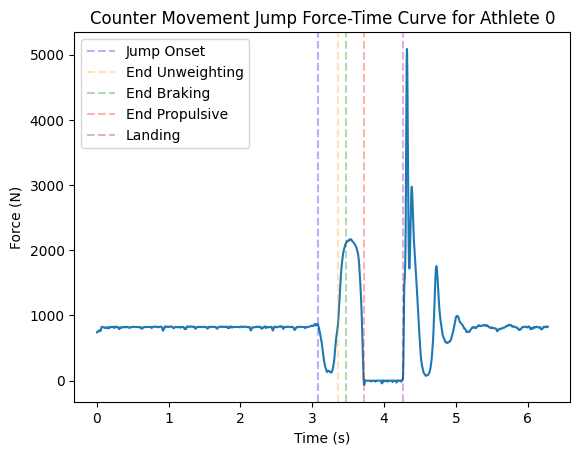

In [6]:
# Plot CMJ of Each Athlete

#Retrieve Athlete data and phase timings
athlete = 0 #Change number to plot different athletes
athlete_data = sum_force.iloc[athlete, :]
onset = onset_time[athlete]
unweight = unweighting_end_times.loc[athlete, 'End of Unweighting Phase']
braking = braking_end_times.loc[athlete, 'End of Braking Phase']
propulsive = propulsive_end_times.loc[athlete, 'End of Propulsive Phase']
landing = landing_time[athlete]

#Plot CMJ with phases
plt.figure()
plt.plot(athlete_data.index, athlete_data.values, linestyle = '-' )
plt.title(f'Counter Movement Jump Force-Time Curve for Athlete {athlete}')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.axvline(x=onset, color='blue', linestyle='--', alpha=0.3, label='Jump Onset')
plt.axvline(x=unweight, color='orange', linestyle='--', alpha=0.3, label='End Unweighting')
plt.axvline(x=braking, color='green', linestyle='--', alpha=0.3, label='End Braking')
plt.axvline(x=propulsive, color='red', linestyle='--', alpha=0.3, label='End Propulsive')
plt.axvline(x=landing, color='purple', linestyle='--', alpha=0.3, label='Landing')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Task 1
# Relationship between Jump Height and other metrics
cmj = sm.ols(
   formula="Q('Jump Height (m)') ~ Q('RSI_mod') + Q('Peak Relative Propulsive Power (W/kg)') + "
            "Q('Propulsive Impulse (Ns)') + Q('Net Eccentric Impulse (Ns)') + "
            "Q('Relative Peak Landing Force (N)') + Q('Peak Landing Force (N)') + "
            "Q('Relative Average Propulsive Force (N)') + Q('Average Propulsive Force (N)') + "
            "Q('Relative Peak Propulsive Force (N)') + Q('Peak Propulsive Force (N)') + "
            "Q('Relative Average Braking Force (N)') + Q('Average Braking Force (N)') + "
            "Q('Relative Peak Braking Force (N)') + Q('Peak Braking Force (N)')",
    data=athlete_output,
).fit()
print(cmj.summary())


To address the task of determining the relationship between jump height and other CMJ metrics, I decided to use a multiple linear regression model. Based off the results of our multiple linear regression, it seems that a combination of 14 of our CMJ metrics explain 99.1% of the variance in jump height. The most significant predictors of jump height were:

1) *Propulsive Impulse (Ns)*: This makes alot of sense since jump height will most likely be affected the most by the forces exerted in the upward/ 'concentric' phase of the jump, as well as by the rate of force production rather than peak forces since that can be affected by factors such as body mass. 

2) *Relative Average Propulsive Force*: This factor surprised me at first as I expected relative peak propulsive force to be more relevant. However, upon further consideration it does make sense that exerting a greater average force over the entire upward phase of the jump would be more predictive of jump height rather than a single peak value. 

3) *Relative Peak Landing Force (N) and Peak Landing Force (N)*: These variables make sense as predictors in our model since a greater jump height would lead to greater relative peak and peak landing forces. However, it is unclear to me at this time if these variables offer insight into player development / training (will need to look into this!). 



    Athlete Predicted Draft Rd
27        8                  6
28        9                  3
29       10                  6
30       10                  6
31       10                  6
32       11                  6
33       11                  3
34       11                  3
35       11                  6
36       12                  4
37       13                  6
38       14                  6
39       15                  6


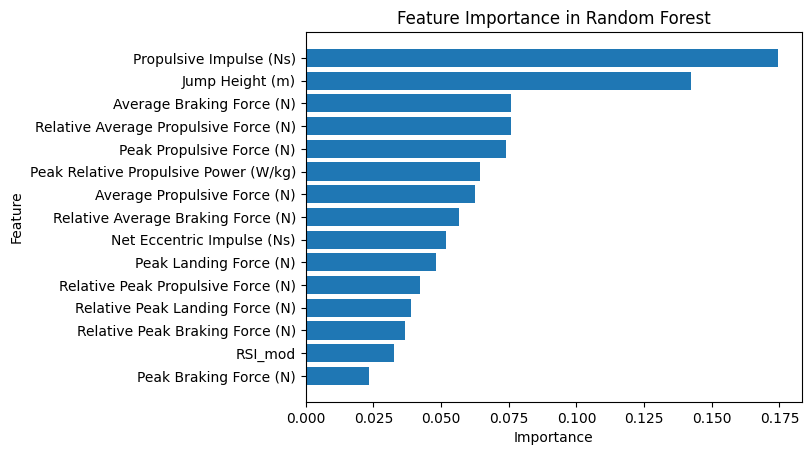

In [12]:
# Task 2
# Predict the Draft Round of Athletes 8, 9, 10, 11, 12, 13, 14, 15
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Create Training and Test sets
athlete_output.replace('?', np.nan, inplace = True)

known_drafts = athlete_output[athlete_output['Draft Rd'].notnull()]
unknown_drafts = athlete_output[athlete_output['Draft Rd'].isnull()].copy()

X_train = known_drafts.iloc[:, 3:]
Y_train = known_drafts.iloc[:, 2]

X_test = unknown_drafts.iloc[:, 3:]

#Initialize and fit model
model = RandomForestClassifier(random_state = 42)
model.fit(X_train , Y_train)

#Make predictions on the test set
predictions = model.predict(X_test)

#Add predictions back to test set
unknown_drafts['Predicted Draft Rd'] = predictions

print(unknown_drafts[['Athlete' , 'Predicted Draft Rd']])

#Extract important features
importances = model.feature_importances_

features = X_train.columns.tolist()

feature_importances = pd.DataFrame({
    'feature' : features,
    'importance' : importances
    })

feature_importances = feature_importances.sort_values(by = 'importance', ascending = False)

plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

To address the task of predicting the draft round of half of the athletes, I decided to use a random forest classifier to handle the relatively small sample size of 40 athletes, and to be able to provide feature importance.
After training the model on the existing athlete data, the model predicted the draft rounds for the remaining athletes which ranged from 3rd to 6th round drafts. Upon retrieving and plotting the importance of each feature, we can see that Propulsive Impulse (Ns) and Jump Height (m) were the most important features in our model for predicting draft round.  